In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import pandas as pd
import numpy as np
from pathlib import Path
import glob
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')



2026-01-13 16:46:16.956059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
class FinalMultimodalDataProcessor:
    def __init__(self, base_path="DatasetCercetare"):
        self.base_path = base_path
        self.sessions_data = {}

    def get_all_sessions(self):
        """Get all unique session names from the file structure"""
        # Get session names from AudioFeatures (since they're shared)
        audio_files = glob.glob(f"{self.base_path}/AudioFeatures/*.csv")
        sessions = [Path(file).stem for file in audio_files]
        return sessions

    def get_people_in_session(self, session_name):
        """Get the people involved in a session from ActionUnits files"""
        au_files = glob.glob(f"{self.base_path}/ActionUnits/*_on_{session_name}.csv")
        people = []
        for file in au_files:
            filename = Path(file).stem
            person = filename.split('_on_')[0]
            people.append(person)
        return people

    def load_person_data(self, person, session_name):
        """Load data for a specific person in a session"""
        person_data = {}

        print(f"  Loading data for {person} in session {session_name}")

        # Load Action Units for this person
        au_file = f"{self.base_path}/ActionUnits/{person}_on_{session_name}.csv"
        if Path(au_file).exists():
            au_df = pd.read_csv(au_file)
            au_features = ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09',
                          'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23',
                          'AU25', 'AU26', 'AU28']
            person_data['action_units'] = au_df[['timestamp'] + au_features]
            print(f"    Action Units: {au_df.shape}")

        # Load Hand Gestures for this person
        hg_file = f"{self.base_path}/HandGestures/{person}_on_{session_name}.csv"
        if Path(hg_file).exists():
            hg_df = pd.read_csv(hg_file)
            hg_features = ['left_hand_velocity', 'right_hand_velocity',
                          'gesture_frequency_cumulative', 'face_touches_cumulative']
            person_data['hand_gestures'] = hg_df[['timestamp'] + hg_features]
            print(f"    Hand Gestures: {hg_df.shape}")

        # Load shared Audio Features (same for all people in session)
        audio_file = f"{self.base_path}/AudioFeatures/{session_name}.csv"
        if Path(audio_file).exists():
            audio_df = pd.read_csv(audio_file)
            audio_features = ['energy_db', 'pitch_hz', 'speaking_rate']
            audio_df = audio_df.rename(columns={'time_seconds': 'timestamp'})
            person_data['audio'] = audio_df[['timestamp'] + audio_features]
            print(f"    Audio Features: {audio_df.shape}")

        # Load shared Sentiment Analysis (filter by speaker if available)
        sent_file = f"{self.base_path}/SentimentAnalysis/{session_name}.csv"
        if Path(sent_file).exists():
            sent_df = pd.read_csv(sent_file)
            sent_df = sent_df.rename(columns={'second': 'timestamp'})

            # Filter by speaker if the person name matches
            if 'speaker' in sent_df.columns:
                # Try to match person name with speaker (case insensitive)
                person_sent = sent_df[sent_df['speaker'].str.lower() == person.lower()]
                if len(person_sent) > 0:
                    person_data['sentiment'] = person_sent[['timestamp', 'compound', 'pos', 'neu', 'neg']]
                    print(f"    Sentiment (filtered for {person}): {person_sent.shape}")
                else:
                    # If no match, use aggregated sentiment for all speakers
                    sent_agg = sent_df.groupby('timestamp').agg({
                        'compound': 'mean', 'pos': 'mean', 'neu': 'mean', 'neg': 'mean'
                    }).reset_index()
                    person_data['sentiment'] = sent_agg
                    print(f"    Sentiment (aggregated): {sent_agg.shape}")
            else:
                person_data['sentiment'] = sent_df[['timestamp', 'compound', 'pos', 'neu', 'neg']]
                print(f"    Sentiment: {sent_df.shape}")

        return person_data

    def align_person_data(self, person_data, target_fps=1.0):
        """Align all modalities for a person to the same temporal grid"""

        # Find common time range
        min_time = 0
        max_time = float('inf')

        for modality, data in person_data.items():
            if len(data) > 0:
                min_time = max(min_time, data['timestamp'].min())
                max_time = min(max_time, data['timestamp'].max())

        # Create target timeline
        target_timeline = np.arange(int(min_time), int(max_time) + 1)
        aligned_data = pd.DataFrame({'timestamp': target_timeline})

        # Align each modality
        for modality, data in person_data.items():
            if modality == 'audio':
                # Aggregate high-frequency audio to 1-second intervals
                audio_agg = data.groupby(data['timestamp'].round()).agg({
                    'energy_db': 'mean',
                    'pitch_hz': 'mean',
                    'speaking_rate': 'mean'
                }).reset_index()
                aligned_data = aligned_data.merge(audio_agg, on='timestamp', how='left')

            else:
                # For other modalities, use nearest second matching
                data_rounded = data.copy()
                data_rounded['timestamp'] = data_rounded['timestamp'].round().astype(int)
                data_agg = data_rounded.groupby('timestamp').first().reset_index()
                aligned_data = aligned_data.merge(data_agg, on='timestamp', how='left')

        # Fill missing values
        aligned_data = aligned_data.fillna(method='ffill').fillna(0)

        return aligned_data

    def process_all_data(self):
        """Process all sessions and people"""
        sessions = self.get_all_sessions()
        print(f"Found sessions: {sessions}")

        all_processed_data = {}

        for session in sessions:
            print(f"\n=== Processing Session: {session} ===")
            people = self.get_people_in_session(session)
            print(f"People in session: {people}")

            session_data = {}

            for person in people:
                # Load person's data
                person_data = self.load_person_data(person, session)

                # Align temporal data
                aligned_data = self.align_person_data(person_data)

                # Add person and session info
                aligned_data['person'] = person
                aligned_data['session'] = session

                print(f"    {person} final shape: {aligned_data.shape}")
                print(f"    {person} features: {[col for col in aligned_data.columns if col not in ['timestamp', 'person', 'session']]}")

                session_data[person] = aligned_data
                all_processed_data[f"{session}_{person}"] = aligned_data

            self.sessions_data[session] = session_data

        return all_processed_data

# Process all data
processor = FinalMultimodalDataProcessor("../DatasetCercetare")
all_data = processor.process_all_data()

print("\n" + "="*60)
print("FINAL DATA SUMMARY")
print("="*60)
for key, data in all_data.items():
    print(f"{key}:")
    print(f"  Shape: {data.shape}")
    print(f"  Duration: {data['timestamp'].max() - data['timestamp'].min():.0f} seconds")
    print(f"  Features: {len([col for col in data.columns if col not in ['timestamp', 'person', 'session']])}")
    print()

Found sessions: ['NateAlexis', 'EliGianna', 'DaemahniGianna', 'SarahTexas', 'StephenMiette', 'ZahariahErin', 'ChaseGianna', 'StephenKeala', 'MarshallBritney']

=== Processing Session: NateAlexis ===
People in session: ['Alexis', 'Nate']
  Loading data for Alexis in session NateAlexis
    Action Units: (193, 18)
    Hand Gestures: (104, 15)
    Audio Features: (8318, 12)
    Alexis final shape: (177, 27)
    Alexis features: ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28', 'left_hand_velocity', 'right_hand_velocity', 'gesture_frequency_cumulative', 'face_touches_cumulative', 'energy_db', 'pitch_hz', 'speaking_rate']
  Loading data for Nate in session NateAlexis
    Action Units: (193, 18)
    Hand Gestures: (28, 15)
    Audio Features: (8318, 12)
    Nate final shape: (119, 27)
    Nate features: ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 

In [8]:
ground_truth = {
    'session_person': [
        'NateAlexis_Alexis',
        'MarshallBritney_Britney',
        'ChaseGianna_Chase',
        'DaemahniGianna_Daemahni',
        'EliGianna_Eli',
        'ZahariahErin_Erin',
        'ChaseGianna_Gianna',
        'DaemahniGianna_Gianna',
        'EliGianna_Gianna',
        'StephenKeala_Keala',
        'MarshallBritney_Marshall',
        'StephenMiette_Miette',
        'NateAlexis_Nate',
        'SarahTexas_Sarah',
        'StephenKeala_Stephen',
        'StephenMiette_Stephen',
        'SarahTexas_Texas',
        'ZahariahErin_Zahariah'
    ],
    'is_attracted': [
        1,  # Alexis_on_NateAlexis
        1,  # Britney_on_MarshallBritney
        1,  # Chase_on_ChaseGianna
        1,  # Daemahni_on_DaemahniGianna
        1,  # Eli_on_EliGianna
        0,  # Erin_on_ZahariahErin
        0,  # Gianna_on_ChaseGianna
        1,  # Gianna_on_DaemahniGianna
        0,  # Gianna_on_EliGianna
        0,  # Keala_on_StephenKeala
        1,  # Marshall_on_MarshallBritney
        1,  # Miette_on_StephenMiette
        0,  # Nate_on_NateAlexis
        1,  # Sarah_on_SarahTexas
        0,  # Stephen_on_StephenKeala
        1,  # Stephen_on_StephenMiette
        1,  # Texas_on_SarahTexas
        1   # Zahariah_on_ZahariahErin
    ]
}

ground_truth_df = pd.DataFrame(ground_truth)
print("Ground Truth Labels:")
print(ground_truth_df)
print()

Ground Truth Labels:
              session_person  is_attracted
0          NateAlexis_Alexis             1
1    MarshallBritney_Britney             1
2          ChaseGianna_Chase             1
3    DaemahniGianna_Daemahni             1
4              EliGianna_Eli             1
5          ZahariahErin_Erin             0
6         ChaseGianna_Gianna             0
7      DaemahniGianna_Gianna             1
8           EliGianna_Gianna             0
9         StephenKeala_Keala             0
10  MarshallBritney_Marshall             1
11      StephenMiette_Miette             1
12           NateAlexis_Nate             0
13          SarahTexas_Sarah             1
14      StephenKeala_Stephen             0
15     StephenMiette_Stephen             1
16          SarahTexas_Texas             1
17     ZahariahErin_Zahariah             1



In [9]:
class MultimodalDataPreprocessor:
    """Handles data preprocessing and normalization for multimodal attraction data"""

    def __init__(self, sequence_length=15):
        self.sequence_length = sequence_length
        self.feature_scaler = StandardScaler()
        self.feature_names = None
        self.is_fitted = False
        
        # 1. HARDCODED CANONICAL FEATURE LIST
        self.canonical_feature_names = [
            'AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 
            'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28', 'left_hand_velocity', 
            'right_hand_velocity', 'gesture_frequency_cumulative', 'face_touches_cumulative', 
            'energy_db', 'pitch_hz', 'speaking_rate', 'compound', 'pos', 'neu', 'neg'
        ]

    def create_sequences(self, all_data, ground_truth_df):
        """Create sequences for RNN training"""
        X_sequences = []
        y_labels = []
        sequence_info = []

        print("Creating sequences...")
        
        # Use the hardcoded canonical list
        self.feature_names = self.canonical_feature_names
        
        # Define columns to drop for clean feature data
        non_feature_cols = ['timestamp', 'person', 'session']


        for key, data in all_data.items():
            # Get label for this person
            label_row = ground_truth_df[ground_truth_df['session_person'] == key]
            if len(label_row) == 0:
                continue

            label = label_row['is_attracted'].iloc[0]

            # Remove non-feature columns
            # Use errors='ignore' in case some datasets don't have all non-feature columns
            feature_data = data.drop(non_feature_cols, axis=1, errors='ignore')

            # 2. ENFORCE THE CANONICAL FEATURE SET
            # Use .reindex() to ensure all 28 columns are present.
            # If a column is missing (like 'compound' in 24-feature data), it is added and filled with 0.0.
            feature_data = feature_data.reindex(columns=self.feature_names, fill_value=0.0)
            
            # --- Sanity Check (Optional but Recommended) ---
            # Now, every feature_data MUST have exactly len(self.feature_names) columns
            if feature_data.shape[1] != len(self.feature_names):
                 raise RuntimeError(f"Feature count mismatch for {key}. Expected {len(self.feature_names)}, got {feature_data.shape[1]}")
            # ---------------------------------------------


            # Create overlapping sequences
            for i in range(len(feature_data) - self.sequence_length + 1):
                # sequence will now consistently have shape (15, 28)
                sequence = feature_data.iloc[i:i + self.sequence_length].values
                X_sequences.append(sequence)
                y_labels.append(label)
                sequence_info.append({
                    'person': key,
                    'start_time': i,
                    'end_time': i + self.sequence_length - 1
                })

        # X = np.array(X_sequences) should now successfully create a 3D array of shape (N, 15, 28)
        X = np.array(X_sequences) 
        y = np.array(y_labels)

        print(f"Created {len(X)} sequences")
        print(f"Sequence shape: {X.shape}") # Should show (N, 15, 28)
        print(f"Features: {len(self.feature_names)}")
        print(f"Class distribution: {np.bincount(y)}")

        return X, y, sequence_info
        
    def fit_normalizer(self, X_train):
        """Fit the feature normalizer on training data"""
        print("Fitting feature normalizer...")

        # Reshape for normalization (samples*time, features)
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])

        # Fit scaler
        self.feature_scaler.fit(X_train_reshaped)
        self.is_fitted = True

        print("Feature normalizer fitted!")
        return self

    def normalize_features(self, X):
        """Normalize features using fitted scaler"""
        if not self.is_fitted:
            raise ValueError("Normalizer not fitted! Call fit_normalizer() first.")

        # Reshape for normalization
        original_shape = X.shape
        X_reshaped = X.reshape(-1, X.shape[-1])

        # Transform
        X_normalized = self.feature_scaler.transform(X_reshaped)
        X_normalized = X_normalized.reshape(original_shape)

        return X_normalized

    def split_by_person(self, X, y, sequence_info, validation_split=0.2):
        """Split data by person to avoid data leakage"""
        print("Splitting data by person...")

        # Group sequences by person
        person_sequences = {}
        for i, info in enumerate(sequence_info):
            person = info['person']
            if person not in person_sequences:
                person_sequences[person] = []
            person_sequences[person].append(i)

        # Split by person
        train_indices = []
        val_indices = []

        for person, indices in person_sequences.items():
            n_val = max(1, int(len(indices) * validation_split))
            val_indices.extend(indices[-n_val:])  # Last sequences for validation
            train_indices.extend(indices[:-n_val])  # Rest for training

        X_train = X[train_indices]
        X_val = X[val_indices]
        y_train = y[train_indices]
        y_val = y[val_indices]

        print(f"Train set: {len(X_train)} sequences")
        print(f"Val set: {len(X_val)} sequences")
        print(f"Train class distribution: {np.bincount(y_train)}")
        print(f"Val class distribution: {np.bincount(y_val)}")

        return X_train, X_val, y_train, y_val, train_indices, val_indices

    def prepare_training_data(self, all_data, ground_truth_df, validation_split=0.2):
        """Complete data preparation pipeline"""
        # Create sequences
        X, y, sequence_info = self.create_sequences(all_data, ground_truth_df)

        # Split by person
        X_train, X_val, y_train, y_val, train_idx, val_idx = self.split_by_person(
            X, y, sequence_info, validation_split
        )

        # Fit normalizer on training data
        self.fit_normalizer(X_train)

        # Normalize both sets
        X_train_norm = self.normalize_features(X_train)
        X_val_norm = self.normalize_features(X_val)

        return {
            'X_train': X_train_norm,
            'X_val': X_val_norm,
            'y_train': y_train,
            'y_val': y_val,
            'train_indices': train_idx,
            'val_indices': val_idx,
            'sequence_info': sequence_info
        }

    def preprocess_new_data(self, person_data):
        """Preprocess new data for prediction"""
        if not self.is_fitted:
            raise ValueError("Preprocessor not fitted! Train model first.")

        # Remove non-feature columns
        feature_data = person_data.drop(['timestamp', 'person', 'session'], axis=1, errors='ignore')

        # Create sequences
        sequences = []
        for i in range(len(feature_data) - self.sequence_length + 1):
            sequence = feature_data.iloc[i:i + self.sequence_length].values
            sequences.append(sequence)

        if len(sequences) == 0:
            raise ValueError(f"Not enough data points. Need at least {self.sequence_length} time steps.")

        X = np.array(sequences)
        X_normalized = self.normalize_features(X)

        return X_normalized


In [10]:
# Initialize preprocessor
print("="*60)
print("DATA PREPROCESSING")
print("="*60)

preprocessor = MultimodalDataPreprocessor(sequence_length=15)
data_dict = preprocessor.prepare_training_data(all_data, ground_truth_df)

print(f"\nPreprocessing complete!")
print(f"Training data shape: {data_dict['X_train'].shape}")
print(f"Validation data shape: {data_dict['X_val'].shape}")
print(f"Feature names: {preprocessor.feature_names[:28]}")

DATA PREPROCESSING
Creating sequences...
Created 1535 sequences
Sequence shape: (1535, 15, 28)
Features: 28
Class distribution: [ 436 1099]
Splitting data by person...
Train set: 1235 sequences
Val set: 300 sequences
Train class distribution: [350 885]
Val class distribution: [ 86 214]
Fitting feature normalizer...
Feature normalizer fitted!

Preprocessing complete!
Training data shape: (1235, 15, 28)
Validation data shape: (300, 15, 28)
Feature names: ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28', 'left_hand_velocity', 'right_hand_velocity', 'gesture_frequency_cumulative', 'face_touches_cumulative', 'energy_db', 'pitch_hz', 'speaking_rate', 'compound', 'pos', 'neu', 'neg']


In [11]:
class AttractionLSTMModel:
    """LSTM model for attraction prediction"""

    def __init__(self):
        self.model = None
        self.history = None

    def build_model(self, input_shape):
        """Build LSTM model architecture"""
        model = Sequential([
            # First LSTM layer
            LSTM(64, return_sequences=True, input_shape=input_shape, dropout=0.2),
            BatchNormalization(),

            # Second LSTM layer
            LSTM(32, return_sequences=True, dropout=0.2),
            BatchNormalization(),

            # Third LSTM layer
            LSTM(16, dropout=0.2),
            BatchNormalization(),

            # Dense layers
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dropout(0.2),

            # Output layer
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=16):
        """Train the model"""
        if self.model is None:
            input_shape = (X_train.shape[1], X_train.shape[2])
            self.build_model(input_shape)

        print("\nModel Architecture:")
        self.model.summary()

        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=20, restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
            )
        ]

        # Handle class imbalance
        class_weight = None
        if len(np.unique(y_train)) > 1:
            from sklearn.utils.class_weight import compute_class_weight
            classes = np.unique(y_train)
            weights = compute_class_weight('balanced', classes=classes, y=y_train)
            class_weight = {classes[i]: weights[i] for i in range(len(classes))}
            print(f"Class weights: {class_weight}")

        print("\nTraining model...")
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=1
        )

        return self.history

    def predict(self, X):
        """Make predictions"""
        if self.model is None:
            raise ValueError("Model not trained!")
        return self.model.predict(X)

    def evaluate(self, X, y):
        """Evaluate model performance"""
        if self.model is None:
            raise ValueError("Model not trained!")
        return self.model.evaluate(X, y)


In [12]:
print("="*60)
print("MODEL TRAINING")
print("="*60)

attraction_model = AttractionLSTMModel()
history = attraction_model.train(
    data_dict['X_train'],
    data_dict['y_train'],
    data_dict['X_val'],
    data_dict['y_val']
)

MODEL TRAINING

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 64)         │        23,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,897 (159.75 KB)

 Trainable params: 40,673 (158.88 KB)

 Non-trainable params: 224 (896.00 B)

Class weights: {0: 1.7642857142857142, 1: 0.6977401129943502}

Training model...
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6024 - loss: 0.6466 - precision: 0.8157 - recall: 0.5751 - val_accuracy: 0.8533 - val_loss: 0.6064 - val_precision: 0.9087 - val_recall: 0.8832 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7263 - loss: 0.5459 - precision: 0.8804 - recall: 0.7153 - val_accuracy: 0.8433 - val_loss: 0.4380 - val_precision: 0.9196 - val_recall: 0.8551 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7676 - loss: 0.4798 - precision: 0.9062 - recall: 0.7537 - val_accuracy: 0.8267 - val_loss: 0.3999 - val_precision: 0.9355 - val_recall: 0.8131 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8057 - loss: 0.4136 - precision: 0.9364 - recall: 0.7819 - val_accuracy: 0.8400 - val_loss: 0.3455 - val_precision: 0.9511 - val_recall: 0.8178 - learn

In [13]:
best_val_loss = min(attraction_model.history.history['val_loss'])
best_val_acc = max(attraction_model.history.history['val_accuracy'])

print(f"\nBest validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Evaluate on validation set
print("\nFinal model performance:")
val_loss, val_acc, val_precision, val_recall = attraction_model.evaluate(
    data_dict['X_val'],
    data_dict['y_val'],
)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Test predictions on validation set
val_predictions = attraction_model.predict(data_dict['X_val'])
val_pred_binary = (val_predictions > 0.5).astype(int)

print(f"\nPrediction distribution:")
print(f"Predicted 0 (not attracted): {np.sum(val_pred_binary == 0)}")
print(f"Predicted 1 (attracted): {np.sum(val_pred_binary == 1)}")
print(f"Actual 0 (not attracted): {np.sum(data_dict['y_val'] == 0)}")
print(f"Actual 1 (attracted): {np.sum(data_dict['y_val'] == 1)}")


Best validation loss: 0.2021
Best validation accuracy: 0.9300

Final model performance:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9200 - loss: 0.2021 - precision: 0.9657 - recall: 0.9206 
Validation Loss: 0.2021
Validation Accuracy: 0.9200
Validation Precision: 0.9657
Validation Recall: 0.9206
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Prediction distribution:
Predicted 0 (not attracted): 96
Predicted 1 (attracted): 204
Actual 0 (not attracted): 86
Actual 1 (attracted): 214


In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
STARTING MODALITY ABLATION STUDY
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

TRAINING ON:  Action Units (AUs)
Initialized with modalities: ['action_units']
Total features: 17
Features: ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28']

Creating sequences with 17 features...
✓ Created 1535 sequences
✓ Sequence shape: (1535, 15, 17)
✓ Class distribution: [ 436 1099]

Train set:  (1235, 15, 17)
Val set: (300, 15, 17)
Train class distribution: [350 885]
Val class distribution: [ 86 214]

Model Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 15, 34)         │         7,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 15, 34)         │           136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 15, 17)         │         3,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 15, 17)         │            68 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 8)              │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,509 (48.86 KB)

 Trainable params: 12,391 (48.40 KB)

 Non-trainable params: 118 (472.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6437 - loss: 0.7146 - precision_4: 0.7277 - recall_4: 0.8034 - val_accuracy: 0.5367 - val_loss: 0.6864 - val_precision_4: 1.0000 - val_recall_4: 0.3505 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6340 - loss: 0.6674 - precision_4: 0.7779 - recall_4: 0.6847 - val_accuracy: 0.5567 - val_loss: 0.6609 - val_precision_4: 0.9551 - val_recall_4: 0.3972 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6227 - loss: 0.6448 - precision_4: 0.8179 - recall_4: 0.6090 - val_accuracy: 0.6033 - val_loss: 0.6095 - val_precision_4: 0.9204 - val_recall_4: 0.4860 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6000 - loss: 0.6462 - precision_4: 0.8319 - recall_4: 0.5537 - val_accuracy: 0.6200 - val_loss: 0.5995 - val_precision_4: 0.8846 - val_recall_4: 0.5374 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 15, 32)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 15, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 15, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,617 (37.57 KB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5684 - loss: 0.7025 - precision_5: 0.7268 - recall_5: 0.6373 - val_accuracy: 0.4100 - val_loss: 0.7020 - val_precision_5: 1.0000 - val_recall_5: 0.1729 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5409 - loss: 0.6765 - precision_5: 0.7573 - recall_5: 0.5288 - val_accuracy: 0.5000 - val_loss: 0.6859 - val_precision_5: 0.8810 - val_recall_5: 0.3458 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5409 - loss: 0.6715 - precision_5: 0.7641 - recall_5: 0.5198 - val_accuracy: 0.5167 - val_loss: 0.6539 - val_precision_5: 0.8876 - val_recall_5: 0.3692 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5595 - loss: 0.6558 - precision_5: 0.7846 - recall_5: 0.5311 - val_accuracy: 0.5400 - val_loss: 0.6411 - val_precision_5: 1.0000 - val_recall_5: 0.3551 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 15, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 15, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 15, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,601 (37.50 KB)

 Trainable params: 9,489 (37.07 KB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5053 - loss: 0.7126 - precision_6: 0.7224 - recall_6: 0.5028 - val_accuracy: 0.7133 - val_loss: 0.6876 - val_precision_6: 0.8019 - val_recall_6: 0.7944 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5117 - loss: 0.7091 - precision_6: 0.7260 - recall_6: 0.5119 - val_accuracy: 0.6433 - val_loss: 0.6891 - val_precision_6: 0.8497 - val_recall_6: 0.6075 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5312 - loss: 0.6847 - precision_6: 0.7484 - recall_6: 0.5209 - val_accuracy: 0.6033 - val_loss: 0.6759 - val_precision_6: 0.7093 - val_recall_6: 0.7523 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5449 - loss: 0.6898 - precision_6: 0.7504 - recall_6: 0.5469 - val_accuracy: 0.5733 - val_loss: 0.6585 - val_precision_6: 0.7087 - val_recall_6: 0.6822 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 15, 32)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 15, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 15, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,617 (37.57 KB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3174 - loss: 0.7664 - precision_7: 0.6909 - recall_7: 0.0859 - val_accuracy: 0.6567 - val_loss: 0.6813 - val_precision_7: 0.6975 - val_recall_7: 0.9159 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4526 - loss: 0.6966 - precision_7: 0.7425 - recall_7: 0.3616 - val_accuracy: 0.7167 - val_loss: 0.6816 - val_precision_7: 0.7611 - val_recall_7: 0.8785 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5530 - loss: 0.6775 - precision_7: 0.7614 - recall_7: 0.5480 - val_accuracy: 0.7167 - val_loss: 0.6709 - val_precision_7: 0.7611 - val_recall_7: 0.8785 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6008 - loss: 0.6847 - precision_7: 0.7685 - recall_7: 0.6339 - val_accuracy: 0.7167 - val_loss: 0.6687 - val_precision_7: 0.7611 - val_recall_7: 0.8785 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 15, 56)         │        19,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 15, 56)         │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 15, 28)         │         9,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 15, 28)         │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 14)             │         2,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 14)             │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,385 (126.50 KB)

 Trainable params: 32,189 (125.74 KB)

 Non-trainable params: 196 (784.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5142 - loss: 0.7200 - precision_8: 0.7419 - recall_8: 0.4938 - val_accuracy: 0.7467 - val_loss: 0.6602 - val_precision_8: 0.8382 - val_recall_8: 0.7991 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6494 - loss: 0.6247 - precision_8: 0.8192 - recall_8: 0.6554 - val_accuracy: 0.7933 - val_loss: 0.5407 - val_precision_8: 0.9130 - val_recall_8: 0.7850 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7360 - loss: 0.5207 - precision_8: 0.8909 - recall_8: 0.7198 - val_accuracy: 0.8067 - val_loss: 0.4442 - val_precision_8: 0.9286 - val_recall_8: 0.7897 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7757 - loss: 0.4604 - precision_8: 0.9199 - recall_8: 0.7525 - val_accuracy: 0.7967 - val_loss: 0.4069 - val_precision_8: 0.9227 - val_recall_8: 0.7804 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━

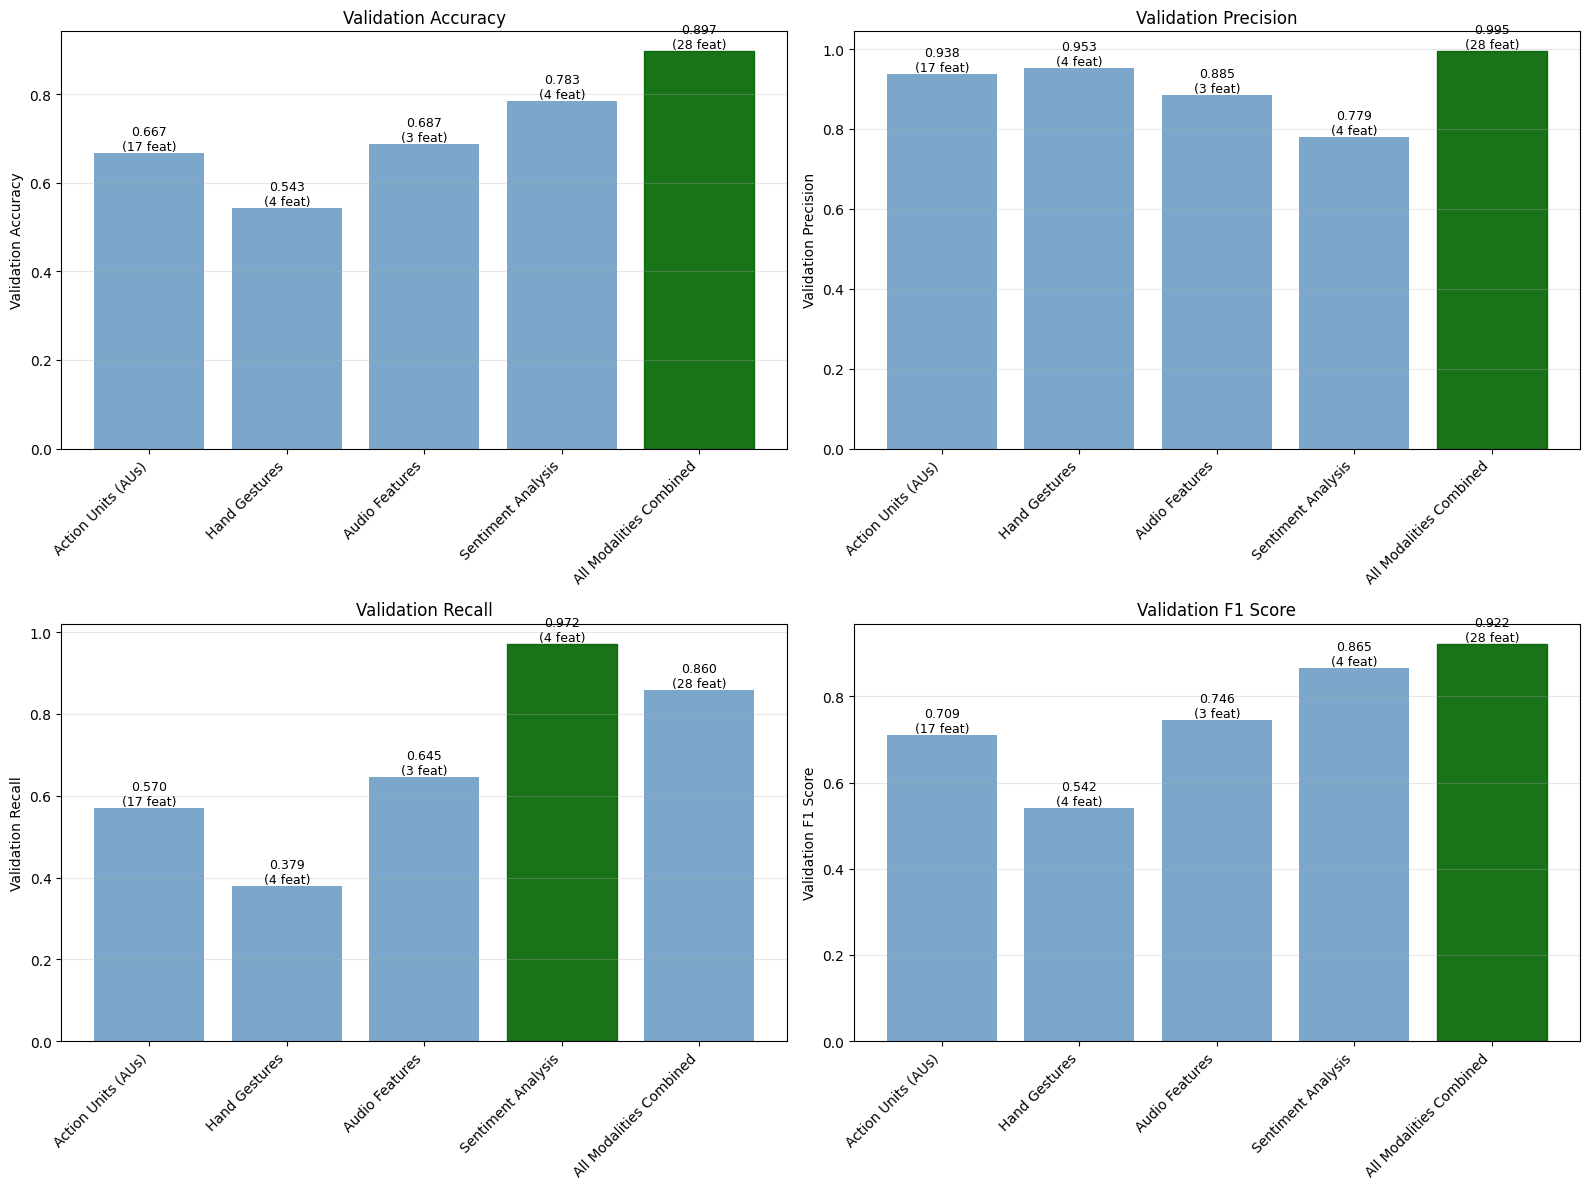


✓ Summary saved to modality_ablation_summary.csv


In [21]:


class ModalityAwarePreprocessor:
    """Enhanced preprocessor that can work with specific modalities"""
    
    # Define modality groups
    MODALITY_GROUPS = {
        'action_units': ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 
                        'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 
                        'AU25', 'AU26', 'AU28'],
        'hand_gestures':  ['left_hand_velocity', 'right_hand_velocity', 
                         'gesture_frequency_cumulative', 'face_touches_cumulative'],
        'audio':  ['energy_db', 'pitch_hz', 'speaking_rate'],
        'sentiment': ['compound', 'pos', 'neu', 'neg']
    }
    
    def __init__(self, sequence_length=15, modalities=None):
        """
        Initialize preprocessor with specific modalities
        
        Args:
            sequence_length: Length of temporal sequences
            modalities: List of modality names to use (e.g., ['action_units', 'audio'])
                       If None, uses all modalities
        """
        self. sequence_length = sequence_length
        self.feature_scaler = StandardScaler()
        self.is_fitted = False
        
        # Set modalities to use
        if modalities is None:
            self.active_modalities = list(self. MODALITY_GROUPS.keys())
        else:
            self.active_modalities = modalities
            
        # Build feature list from active modalities
        self.feature_names = []
        for modality in self.active_modalities:
            self.feature_names.extend(self.MODALITY_GROUPS[modality])
        
        print(f"Initialized with modalities: {self.active_modalities}")
        print(f"Total features: {len(self.feature_names)}")
        print(f"Features: {self.feature_names}")

    def create_sequences(self, all_data, ground_truth_df):
        """Create sequences for RNN training using only selected modalities"""
        X_sequences = []
        y_labels = []
        sequence_info = []

        print(f"\nCreating sequences with {len(self.feature_names)} features...")
        
        non_feature_cols = ['timestamp', 'person', 'session']

        for key, data in all_data.items():
            # Get label
            label_row = ground_truth_df[ground_truth_df['session_person'] == key]
            if len(label_row) == 0:
                continue

            label = label_row['is_attracted'].iloc[0]

            # Remove non-feature columns
            feature_data = data. drop(non_feature_cols, axis=1, errors='ignore')

            # Select only features from active modalities
            feature_data = feature_data. reindex(columns=self.feature_names, fill_value=0.0)
            
            # Sanity check
            if feature_data.shape[1] != len(self.feature_names):
                raise RuntimeError(
                    f"Feature count mismatch for {key}. "
                    f"Expected {len(self.feature_names)}, got {feature_data.shape[1]}"
                )

            # Create overlapping sequences
            for i in range(len(feature_data) - self.sequence_length + 1):
                sequence = feature_data.iloc[i:i + self.sequence_length].values
                X_sequences. append(sequence)
                y_labels.append(label)
                sequence_info.append({
                    'person': key,
                    'start_time': i,
                    'end_time':  i + self.sequence_length - 1
                })

        X = np.array(X_sequences) 
        y = np.array(y_labels)

        print(f"✓ Created {len(X)} sequences")
        print(f"✓ Sequence shape: {X.shape}")
        print(f"✓ Class distribution: {np.bincount(y)}")

        return X, y, sequence_info
        
    def fit_normalizer(self, X_train):
        """Fit the feature normalizer on training data"""
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        self.feature_scaler.fit(X_train_reshaped)
        self.is_fitted = True
        return self

    def normalize_features(self, X):
        """Normalize features using fitted scaler"""
        if not self.is_fitted:
            raise ValueError("Normalizer not fitted! Call fit_normalizer() first.")

        original_shape = X.shape
        X_reshaped = X. reshape(-1, X.shape[-1])
        X_normalized = self.feature_scaler.transform(X_reshaped)
        X_normalized = X_normalized.reshape(original_shape)

        return X_normalized

    def split_by_person(self, X, y, sequence_info, validation_split=0.2):
        """Split data by person to avoid data leakage"""
        person_sequences = {}
        for i, info in enumerate(sequence_info):
            person = info['person']
            if person not in person_sequences:
                person_sequences[person] = []
            person_sequences[person].append(i)

        train_indices = []
        val_indices = []

        for person, indices in person_sequences.items():
            n_val = max(1, int(len(indices) * validation_split))
            val_indices.extend(indices[-n_val:])
            train_indices.extend(indices[:-n_val])

        X_train = X[train_indices]
        X_val = X[val_indices]
        y_train = y[train_indices]
        y_val = y[val_indices]

        return X_train, X_val, y_train, y_val, train_indices, val_indices

    def prepare_training_data(self, all_data, ground_truth_df, validation_split=0.2):
        """Complete data preparation pipeline"""
        X, y, sequence_info = self.create_sequences(all_data, ground_truth_df)
        
        X_train, X_val, y_train, y_val, train_idx, val_idx = self.split_by_person(
            X, y, sequence_info, validation_split
        )

        self.fit_normalizer(X_train)
        X_train_norm = self.normalize_features(X_train)
        X_val_norm = self.normalize_features(X_val)

        return {
            'X_train': X_train_norm,
            'X_val': X_val_norm,
            'y_train':  y_train,
            'y_val': y_val,
            'train_indices': train_idx,
            'val_indices': val_idx,
            'sequence_info': sequence_info
        }


class ModalityAblationStudy:
    """Runs ablation studies across different modalities"""
    
    def __init__(self, all_data, ground_truth_df, sequence_length=15):
        self.all_data = all_data
        self.ground_truth_df = ground_truth_df
        self.sequence_length = sequence_length
        self.results = {}
        
    def build_model(self, input_shape, modality_name=""):
        """Build LSTM model (architecture scales with input size)"""
        # Scale hidden units based on input features
        n_features = input_shape[1]
        
        # Adaptive sizing
        lstm1_units = min(64, max(32, n_features * 2))
        lstm2_units = min(32, max(16, n_features))
        lstm3_units = min(16, max(8, n_features // 2))
        
        model = Sequential([
            LSTM(lstm1_units, return_sequences=True, input_shape=input_shape, dropout=0.2),
            BatchNormalization(),
            
            LSTM(lstm2_units, return_sequences=True, dropout=0.2),
            BatchNormalization(),
            
            LSTM(lstm3_units, dropout=0.2),
            BatchNormalization(),
            
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dropout(0.2),
            
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics. Precision(), tf.keras.metrics.Recall()]
        )

        return model
    
    def train_on_modality(self, modalities, modality_name, epochs=100, batch_size=16):
        """Train model on specific modality/modalities"""
        print("\n" + "="*70)
        print(f"TRAINING ON:  {modality_name}")
        print("="*70)
        
        # Prepare data with selected modalities
        preprocessor = ModalityAwarePreprocessor(
            sequence_length=self.sequence_length,
            modalities=modalities
        )
        
        data = preprocessor.prepare_training_data(
            self.all_data, 
            self.ground_truth_df,
            validation_split=0.2
        )
        
        X_train = data['X_train']
        X_val = data['X_val']
        y_train = data['y_train']
        y_val = data['y_val']
        
        print(f"\nTrain set:  {X_train.shape}")
        print(f"Val set: {X_val.shape}")
        print(f"Train class distribution: {np.bincount(y_train)}")
        print(f"Val class distribution: {np.bincount(y_val)}")
        
        # Build model
        input_shape = (X_train. shape[1], X_train. shape[2])
        model = self.build_model(input_shape, modality_name)
        
        print("\nModel Architecture:")
        model.summary()
        
        # Class weights
        from sklearn.utils.class_weight import compute_class_weight
        classes = np.unique(y_train)
        weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weight = {classes[i]: weights[i] for i in range(len(classes))}
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1
            )
        ]
        
        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=1
        )
        
        # Evaluate
        train_loss, train_acc, train_prec, train_rec = model. evaluate(X_train, y_train, verbose=0)
        val_loss, val_acc, val_prec, val_rec = model.evaluate(X_val, y_val, verbose=0)
        
        # Calculate F1 scores
        train_f1 = 2 * (train_prec * train_rec) / (train_prec + train_rec + 1e-7)
        val_f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-7)
        
        # Store results
        self.results[modality_name] = {
            'modalities': modalities,
            'n_features': X_train.shape[2],
            'history': history,
            'model': model,
            'preprocessor': preprocessor,
            'metrics': {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'train_precision': train_prec,
                'train_recall': train_rec,
                'train_f1': train_f1,
                'val_loss':  val_loss,
                'val_acc': val_acc,
                'val_precision': val_prec,
                'val_recall': val_rec,
                'val_f1': val_f1
            }
        }
        
        print(f"\n{'='*70}")
        print(f"RESULTS FOR:  {modality_name}")
        print(f"{'='*70}")
        print(f"Features used: {X_train.shape[2]}")
        print(f"\nTraining Metrics:")
        print(f"  Accuracy:   {train_acc:.4f}")
        print(f"  Precision: {train_prec:.4f}")
        print(f"  Recall:    {train_rec:.4f}")
        print(f"  F1 Score:  {train_f1:.4f}")
        print(f"\nValidation Metrics:")
        print(f"  Accuracy:   {val_acc:.4f}")
        print(f"  Precision: {val_prec:.4f}")
        print(f"  Recall:    {val_rec:.4f}")
        print(f"  F1 Score:  {val_f1:.4f}")
        
        return self.results[modality_name]
    
    def run_full_ablation(self, epochs=100, batch_size=16):
        """Run ablation study on all individual modalities + combined"""
        
        # Individual modalities
        print("\n" + "🔬" * 35)
        print("STARTING MODALITY ABLATION STUDY")
        print("🔬" * 35)
        
        # 1. Action Units only
        self.train_on_modality(
            ['action_units'], 
            'Action Units (AUs)', 
            epochs=epochs, 
            batch_size=batch_size
        )
        
        # 2. Hand Gestures only
        self.train_on_modality(
            ['hand_gestures'], 
            'Hand Gestures', 
            epochs=epochs, 
            batch_size=batch_size
        )
        
        # 3. Audio only
        self.train_on_modality(
            ['audio'], 
            'Audio Features', 
            epochs=epochs, 
            batch_size=batch_size
        )
        
        # 4. Sentiment only
        self.train_on_modality(
            ['sentiment'], 
            'Sentiment Analysis', 
            epochs=epochs, 
            batch_size=batch_size
        )
        
        # 5. All modalities combined
        self.train_on_modality(
            ['action_units', 'hand_gestures', 'audio', 'sentiment'],
            'All Modalities Combined',
            epochs=epochs,
            batch_size=batch_size
        )
        
        return self.results
    
    def plot_comparison(self, save_path=None):
        """Plot comparison of all modalities"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        modality_names = list(self.results.keys())
        metrics_to_plot = ['val_acc', 'val_precision', 'val_recall', 'val_f1']
        metric_titles = ['Validation Accuracy', 'Validation Precision', 
                        'Validation Recall', 'Validation F1 Score']
        
        for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
            ax = axes[idx // 2, idx % 2]
            
            values = [self.results[name]['metrics'][metric] for name in modality_names]
            n_features = [self.results[name]['n_features'] for name in modality_names]
            
            bars = ax.bar(range(len(modality_names)), values, color='steelblue', alpha=0.7)
            
            # Color the best performing bar
            best_idx = np.argmax(values)
            bars[best_idx].set_color('darkgreen')
            bars[best_idx].set_alpha(0.9)
            
            ax.set_xticks(range(len(modality_names)))
            ax.set_xticklabels(modality_names, rotation=45, ha='right')
            ax.set_ylabel(title)
            ax.set_title(title)
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for i, (bar, val, n_feat) in enumerate(zip(bars, values, n_features)):
                height = bar.get_height()
                ax.text(bar. get_x() + bar.get_width()/2., height,
                       f'{val:.3f}\n({n_feat} feat)',
                       ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\n✓ Plot saved to {save_path}")
        
        plt.show()
    
    def print_summary_table(self):
        """Print a formatted summary table"""
        print("\n" + "="*100)
        print("MODALITY ABLATION STUDY - SUMMARY TABLE")
        print("="*100)
        
        # Create DataFrame for easy viewing
        summary_data = []
        for name, result in self.results.items():
            summary_data.append({
                'Modality': name,
                'N Features': result['n_features'],
                'Val Accuracy': f"{result['metrics']['val_acc']:.4f}",
                'Val Precision': f"{result['metrics']['val_precision']:.4f}",
                'Val Recall': f"{result['metrics']['val_recall']:.4f}",
                'Val F1':  f"{result['metrics']['val_f1']:.4f}",
                'Train Accuracy': f"{result['metrics']['train_acc']:.4f}",
            })
        
        df = pd.DataFrame(summary_data)
        print(df.to_string(index=False))
        print("="*100)
        
        # Find best performing modality
        best_modality = max(self.results. items(), 
                          key=lambda x:  x[1]['metrics']['val_f1'])
        print(f"\n🏆 BEST PERFORMING MODALITY: {best_modality[0]}")
        print(f"   Validation F1 Score: {best_modality[1]['metrics']['val_f1']:.4f}")
        print(f"   Number of Features: {best_modality[1]['n_features']}")
        
        return df


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Assuming you already have: 
    # - all_data:  your processed multimodal data
    # - ground_truth_df: your labels
    
    # Initialize ablation study
    study = ModalityAblationStudy(
        all_data=all_data,
        ground_truth_df=ground_truth_df,
        sequence_length=15
    )
    
    # Run full ablation study
    results = study.run_full_ablation(epochs=100, batch_size=16)
    
    # Print summary table
    summary_df = study.print_summary_table()
    
    # Plot comparison
    study.plot_comparison(save_path='modality_ablation_comparison.png')
    
    # Save summary to CSV
    summary_df.to_csv('modality_ablation_summary.csv', index=False)
    print("\n✓ Summary saved to modality_ablation_summary.csv")

In [22]:
"""
Test custom combinations of modalities
"""

# Test specific combinations
def test_custom_combinations(all_data, ground_truth_df):
    """Test interesting modality combinations"""
    
    study = ModalityAblationStudy(all_data, ground_truth_df, sequence_length=15)
    
    # Test different combinations
    combinations = [
        # Visual only (AU + Hand Gestures)
        (['action_units', 'hand_gestures'], 'Visual Features (AU + Gestures)'),
        
        # Vocal only (Audio + Sentiment)
        (['audio', 'sentiment'], 'Vocal Features (Audio + Sentiment)'),
        
        # Non-verbal (AU + Hand Gestures + Audio)
        (['action_units', 'hand_gestures', 'audio'], 'Non-Verbal Communication'),
        
        # Without sentiment
        (['action_units', 'hand_gestures', 'audio'], 'Without Sentiment'),
        
        # Without audio
        (['action_units', 'hand_gestures', 'sentiment'], 'Without Audio'),
    ]
    
    for modalities, name in combinations:
        study.train_on_modality(modalities, name, epochs=100, batch_size=16)
    
    study.print_summary_table()
    study.plot_comparison(save_path='custom_combinations_comparison.png')
    
    return study.results

# Run custom tests



TRAINING ON:  Visual Features (AU + Gestures)
Initialized with modalities: ['action_units', 'hand_gestures']
Total features: 21
Features: ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28', 'left_hand_velocity', 'right_hand_velocity', 'gesture_frequency_cumulative', 'face_touches_cumulative']

Creating sequences with 21 features...
✓ Created 1535 sequences
✓ Sequence shape: (1535, 15, 21)
✓ Class distribution: [ 436 1099]

Train set:  (1235, 15, 21)
Val set: (300, 15, 21)
Train class distribution: [350 885]
Val class distribution: [ 86 214]

Model Architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 15, 42)         │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 15, 42)         │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 15, 21)         │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 15, 21)         │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 10)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,597 (72.64 KB)

 Trainable params: 18,451 (72.07 KB)

 Non-trainable params: 146 (584.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6081 - loss: 0.7380 - precision_9: 0.7318 - recall_9: 0.7153 - val_accuracy: 0.2867 - val_loss: 0.7079 - val_precision_9: 0.5000 - val_recall_9: 0.0467 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6518 - loss: 0.6358 - precision_9: 0.8191 - recall_9: 0.6599 - val_accuracy: 0.6033 - val_loss: 0.6663 - val_precision_9: 0.8926 - val_recall_9: 0.5047 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6931 - loss: 0.5871 - precision_9: 0.8573 - recall_9: 0.6859 - val_accuracy: 0.7100 - val_loss: 0.5568 - val_precision_9: 0.9922 - val_recall_9: 0.5981 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6947 - loss: 0.5700 - precision_9: 0.8848 - recall_9: 0.6599 - val_accuracy: 0.6833 - val_loss: 0.5255 - val_precision_9: 0.9281 - val_recall_9: 0.6028 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 15, 32)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 15, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 15, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,113 (39.50 KB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6348 - loss: 0.6954 - precision_10: 0.7385 - recall_10: 0.7593 - val_accuracy: 0.5300 - val_loss: 0.6957 - val_precision_10: 0.9294 - val_recall_10: 0.3692 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6170 - loss: 0.6628 - precision_10: 0.7869 - recall_10: 0.6384 - val_accuracy: 0.5967 - val_loss: 0.6589 - val_precision_10: 0.8974 - val_recall_10: 0.4907 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6121 - loss: 0.6545 - precision_10: 0.8133 - recall_10: 0.5955 - val_accuracy: 0.6100 - val_loss: 0.6094 - val_precision_10: 0.8943 - val_recall_10: 0.5140 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6324 - loss: 0.6395 - precision_10: 0.8351 - recall_10: 0.6068 - val_accuracy: 0.6400 - val_loss: 0.5970 - val_precision_10: 0.8955 - val_recall_10: 0.5607 - learning_rate: 0.0010
Epoch 5/100
78/7

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 15, 48)         │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 15, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 15, 24)         │         7,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 15, 24)         │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 12)             │         1,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,097 (94.13 KB)

 Trainable params: 23,929 (93.47 KB)

 Non-trainable params: 168 (672.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6227 - loss: 0.7092 - precision_11: 0.7533 - recall_11: 0.7040 - val_accuracy: 0.5700 - val_loss: 0.6800 - val_precision_11: 0.9885 - val_recall_11: 0.4019 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6211 - loss: 0.6510 - precision_11: 0.7844 - recall_11: 0.6497 - val_accuracy: 0.7133 - val_loss: 0.6111 - val_precision_11: 0.9848 - val_recall_11: 0.6075 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7093 - loss: 0.5536 - precision_11: 0.8673 - recall_11: 0.7017 - val_accuracy: 0.7833 - val_loss: 0.5000 - val_precision_11: 0.9627 - val_recall_11: 0.7243 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7466 - loss: 0.5198 - precision_11: 0.9086 - recall_11: 0.7186 - val_accuracy: 0.8267 - val_loss: 0.3917 - val_precision_11: 1.0000 - val_recall_11: 0.7570 - learning_rate: 0.0010
Epoch 5/100
78/7

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 15, 48)         │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 15, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 15, 24)         │         7,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 15, 24)         │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 12)             │         1,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,097 (94.13 KB)

 Trainable params: 23,929 (93.47 KB)

 Non-trainable params: 168 (672.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6016 - loss: 0.7125 - precision_12: 0.7314 - recall_12: 0.7017 - val_accuracy: 0.4567 - val_loss: 0.6954 - val_precision_12: 0.8806 - val_recall_12: 0.2757 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6429 - loss: 0.6442 - precision_12: 0.7952 - recall_12: 0.6757 - val_accuracy: 0.6300 - val_loss: 0.6140 - val_precision_12: 0.9328 - val_recall_12: 0.5187 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6826 - loss: 0.5853 - precision_12: 0.8487 - recall_12: 0.6780 - val_accuracy: 0.6967 - val_loss: 0.5265 - val_precision_12: 0.9424 - val_recall_12: 0.6121 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7231 - loss: 0.5247 - precision_12: 0.8999 - recall_12: 0.6904 - val_accuracy: 0.7067 - val_loss: 0.4956 - val_precision_12: 0.9091 - val_recall_12: 0.6542 - learning_rate: 0.0010
Epoch 5/100
78/7

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 15, 50)         │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 15, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 15, 25)         │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 15, 25)         │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 12)             │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,933 (101.30 KB)

 Trainable params: 25,759 (100.62 KB)

 Non-trainable params: 174 (696.00 B)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.5474 - loss: 0.7085 - precision_13: 0.7508 - recall_13: 0.5514 - val_accuracy: 0.8067 - val_loss: 0.6437 - val_precision_13: 0.8939 - val_recall_13: 0.8271 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6000 - loss: 0.6478 - precision_13: 0.8088 - recall_13: 0.5785 - val_accuracy: 0.7333 - val_loss: 0.5722 - val_precision_13: 1.0000 - val_recall_13: 0.6262 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6688 - loss: 0.5820 - precision_13: 0.8650 - recall_13: 0.6373 - val_accuracy: 0.7533 - val_loss: 0.5078 - val_precision_13: 1.0000 - val_recall_13: 0.6542 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7344 - loss: 0.5188 - precision_13: 0.8884 - recall_13: 0.7198 - val_accuracy: 0.7767 - val_loss: 0.4425 - val_precision_13: 0.9565 - val_recall_13: 0.7196 - learning_rate: 0.0010
Epoch 5/100
78/7

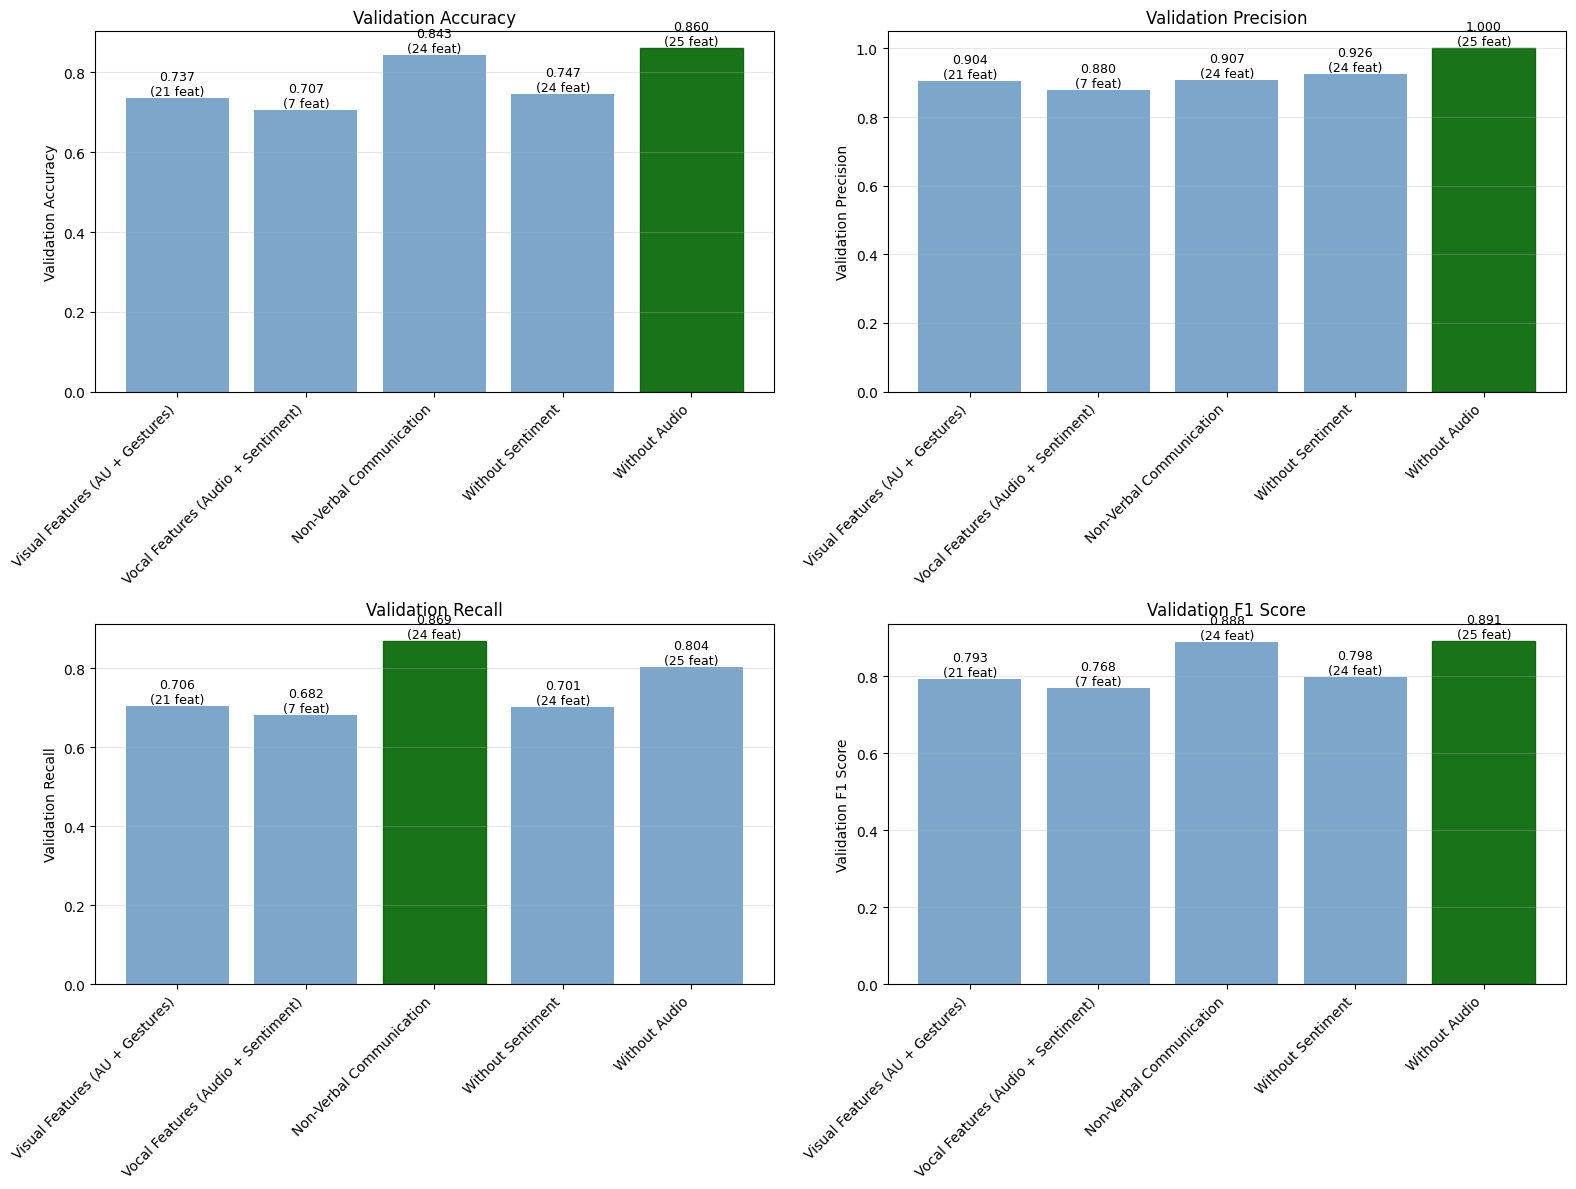

In [23]:
custom_results = test_custom_combinations(all_data, ground_truth_df)

In [24]:
"""
Analyze which specific features contribute most within a modality
"""
import shap
from sklearn.ensemble import RandomForestClassifier

def analyze_feature_importance(preprocessor, X_train, y_train, modality_name):
    """
    Analyze feature importance using Random Forest as a proxy
    (since LSTM feature importance is complex)
    """
    print(f"\n{'='*70}")
    print(f"FEATURE IMPORTANCE ANALYSIS:  {modality_name}")
    print(f"{'='*70}")
    
    # Flatten sequences for RF analysis
    X_flat = X_train.reshape(X_train.shape[0], -1)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(X_flat, y_train)
    
    # Get feature importance (average over time steps)
    n_features = X_train.shape[2]
    n_timesteps = X_train.shape[1]
    
    feature_importance = np.zeros(n_features)
    for i in range(n_features):
        # Average importance across all time steps for this feature
        indices = list(range(i, X_flat.shape[1], n_features))
        feature_importance[i] = rf. feature_importances_[indices]. mean()
    
    # Normalize
    feature_importance = feature_importance / feature_importance.sum()
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': preprocessor.feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
    plt.xlabel('Importance Score')
    plt.title(f'Top 15 Features - {modality_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'feature_importance_{modality_name. replace(" ", "_")}.png', dpi=300)
    plt.show()
    
    return importance_df

ModuleNotFoundError: No module named 'shap'

In [ ]:
best_result = results['Action Units (AUs)']  # or whichever performed best
importance_df = analyze_feature_importance(
    best_result['preprocessor'],
    data['X_train'],
    data['y_train'],
    'Action Units'
)